In [1]:
# import subprocess
# import os

# result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
# output = result.stdout
# for line in output.splitlines():
#     if '=' in line:
#         var, value = line.split('=', 1)
#         os.environ[var] = value


import os

# 设置环境变量
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

# 打印环境变量以确认设置成功
print(os.environ.get('HF_ENDPOINT'))

https://hf-mirror.com


In [2]:
from transformers import GPT2Tokenizer, GPT2Model,AutoModel
import torch
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import Trainer
import evaluate
import numpy as np
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification

2025-02-10 09:46:42.348539: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 09:46:42.362158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-10 09:46:42.378104: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-10 09:46:42.382810: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 09:46:42.394903: I tensorflow/core/platform/cpu_feature_guar

In [3]:
model_name="gpt2_gene_multi_v2_ft"
device="cuda"
tokenizer = AutoTokenizer.from_pretrained("gpt2_gene_multi_v2_ft")
model = AutoModel.from_pretrained(model_name)
model.to(device)

def get_text_embedding(text):
    """
    使用 GPT-2 模型获取文本的向量表示。
    
    参数:
        text (str): 输入文本。
        model_name (str): 预训练 GPT-2 模型名称，默认为 "gpt2"。
        device (str): 设备名称（"cpu" 或 "cuda"）。
    
    返回:
        torch.Tensor: 文本的向量表示，维度为 [hidden_size]。
    """

    # 将文本编码为输入 ID 并添加批量维度
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    
    # 获取模型的隐藏层输出
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # [batch_size, seq_length, hidden_size]
    
    # 平均池化：获取序列中所有词向量的平均值
    embeddings = hidden_states.mean(dim=1).squeeze()  # [hidden_size]
    
    return embeddings

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

def get_sim_score(s1, s2):
    v1 = get_text_embedding(s1)
    v2 = get_text_embedding(s2)
    
    # 假设dna_embedding和protein_embedding为numpy数组
    #similarity = cosine_similarity([v1.cpu().numpy()], [v2.cpu().numpy()])[0][0]
    A = v1.cpu().numpy()
    B = v2.cpu().numpy()
    #similarity =  np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))
    similarity = np.linalg.norm(A - B)
    return similarity

s1 = "ATCCCCCCCCCCCCCCCCCCCCCCCCCCCCC"
s2 = "ATCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC"
s1 = "ATGTCTCTACAGATGATAACGGTCAGTAATAACGTAACTTTAATTCAACCAGGCTTCTCACTGATGAATTTTGATGGACAAGTTTTCTTCTTTGGTCAAAAAGGCTGGCCCAAGAGATCCTGCCCCACAGGAGTTTTCCATTTTGATGTAAAGCATAACCATCTCAAACTGAAGCCTACAGTTTTCTCAAAGGATTCCTGCTACCTTCCTCCTCTTCGCTATCCAGCCACTTGCATATTTAAAGGCAACTTCGAGTCTGAAAAGCATCAGTATATCATCCATGGAGGGAAAACACCAAACAATGAACTTTCAGATAAGATGTATGTCATGTCTATTGTTTGCAAAAACAACAAAAAATTTACTTTTCGCTGCACGGAGAAAGACTTGGTAGGTGATGTTCCTGAAGGCAGATATGGCCATTCCATTGATGTAGTGTATAGTCGAGGGAAAAGTATGGGCGTTCTCTTTGGAGGACGATCTTACATGCCTTCTGCCCAAAGAACCACAGAAAAATGGAACAGTGTAGTTGACTGCTTGCCCCATCTCTTCTTGGTGGATTTTGAATTTGGGTGTTCTACATCCTACATTCTTCCCGAACTTCAGGATGGGATATCTTTTCATGTCTCCATTGCCAGAAATGATACCATTTATATTTTAGGAGGTCATTCACTCACCAATAACATCCGCCCTGCCAATCTGTTCAGAGTAAGGGTTGATCTCCCCCTGGGTAGCCCAGCTGTGAGTTGCACGGTCTTATCAGGAGGAATCTCTGTCTCCAGTGCAATCTTGACTCAAACTAATAATGATGAATTTGTCATTGTTGGTGGCTATCAGCTTGAAAATCAAAAAAGAATGGTCTGCAACATTGTCACTTTAGATGACAACAAGATAGATATTCGTGAGATGGAGGCACCAGATTGGACCCCAGATATTAAGCACAGCAAGGTATGGTTTGGAAACAACATGGGAAATGGGAGTGTTTTCCTTGGAATACCAGGAGACAATAAGCAGGCTGTTTCAGAAGCATTCTATTTCTATATGTTGAAATGTGCTGAAGATGATATAAATGAAGATGAGAAAACATTGATGAACAGTCAGACATCAACAGAAGATCCAGGAGACTCCACACCCTTTGAAGACTCGGAAGAATTTTGCTTCAGTGCAGAAGCAAATAGTTTTGGTGGGGATGATGAATTTGACACCTATAATGAAGATGATGAGGAAGATGAGTCTGAGACAGGCTACTGGATTACGTGTTGCCTTACTTGTAATGTGGATATCAACACTTGGGTACCATTCTACTCAACTGAGCTCAACAAACCTGCTATGATCTACTGCTCTCATGAGGACGGGCACTGGGTCCATGCTCAGTGCATGGATCTGGCAGAGCGCACGCTCATCCATCTGTCAGAAGGAAGCAACAAGTATTATTGCAATGAGCATGTGGAGATAGCAAGAGCACTACAAACCCCCAAAAGAGCCATGCCCTTGAAAAAGCCCCCACTGAAATCCCTCCGCAAAAAAGGCCCTGCAAAAATCTTGACTCCTGCCAAGAAATCCTTCCTTAGAAGATTGTTTGAT"
s2 = "MSLQMITVSNNVTLIQPGFSLMNFDGQVFFFGQKGWPKRSCPTGVFHFDVKHNHLKLKPTVFSKDSCYLPPLRYPATCIFKGNFESEKHQYIIHGGKTPNNELSDKMYVMSIVCKNNKKFTFRCTEKDLVGDVPEGRYGHSIDVVYSRGKSMGVLFGGRSYMPSAQRTTEKWNSVVDCLPHLFLVDFEFGCSTSYILPELQDGISFHVSIARNDTIYILGGHSLTNNIRPANLFRVRVDLPLGSPAVSCTVLSGGISVSSAILTQTNNDEFVIVGGYQLENQKRMVCNIVTLDDNKIDIREMEAPDWTPDIKHSKVWFGNNMGNGSVFLGIPGDNKQAVSEAFYFYMLKCAEDDINEDEKTLMNSQTSTEDPGDSTPFEDSEEFCFSAEANSFGGDDEFDTYNEDDEEDESETGYWITCCLTCNVDINTWVPFYSTELNKPAMIYCSHEDGHWVHAQCMDLAERTLIHLSEGSNKYYCNEHVEIARALQTPKRAMPLKKPPLKSLRKKGPAKILTPAKKSFLRRLFD"
get_sim_score(s1, s2)

39.938614

In [5]:
#模型测试 蛋白质数据集，150长度/450bp，复杂版本 不相似
raw_datasets_dna_protein = load_dataset('dnagpt/gene_lan_transfer', 'dna_protein_pair_rand')['train'].train_test_split(test_size=0.5) #默认已经shuffle
raw_datasets_dna_protein

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label'],
        num_rows: 8000
    })
})

In [6]:
sim_score = []
dif_score = []

for item in raw_datasets_dna_protein["train"]:
    #print(item)
    sentence1 = item["sentence1"]
    sentence2 = item["sentence2"]
    label = item["label"]
    score = get_sim_score(sentence1, sentence2)

    if 1 == label:
        sim_score.append(score)
    else:
        dif_score.append(score)

In [7]:
import numpy as np
print(np.mean(sim_score), np.mean(dif_score))

38.87972 37.672188


In [8]:
print(len(sim_score),len(dif_score))

4047 3953


/root/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from fon

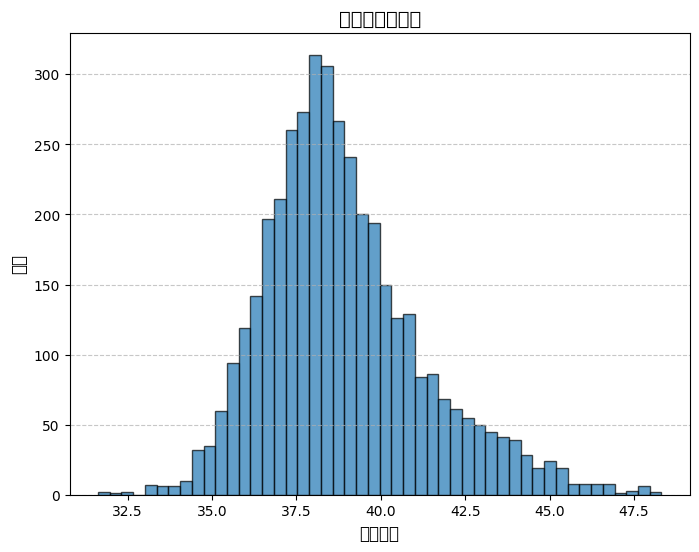

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据（Python list，float 类型）
#data = np.random.normal(loc=50, scale=15, size=200)  # 生成200个服从正态分布的随机数
data = sim_score

# 计算直方图并自动确定分区数
plt.figure(figsize=(8, 6))  # 设置图像大小
plt.hist(data, bins='auto', edgecolor='black', alpha=0.7)

# 添加标题和标签
plt.xlabel('数值区间', fontsize=12)
plt.ylabel('频数', fontsize=12)
plt.title('数值分布直方图', fontsize=14)

# 显示网格
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 显示直方图
plt.show()

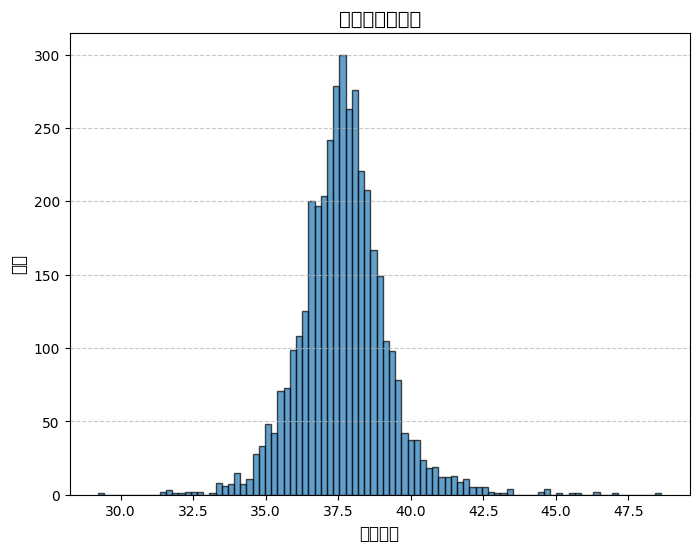

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据（Python list，float 类型）
#data = np.random.normal(loc=50, scale=15, size=200)  # 生成200个服从正态分布的随机数
data = dif_score

# 计算直方图并自动确定分区数
plt.figure(figsize=(8, 6))  # 设置图像大小
plt.hist(data, bins='auto', edgecolor='black', alpha=0.7)

# 添加标题和标签
plt.xlabel('数值区间', fontsize=12)
plt.ylabel('频数', fontsize=12)
plt.title('数值分布直方图', fontsize=14)

# 显示网格
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 显示直方图
plt.show()

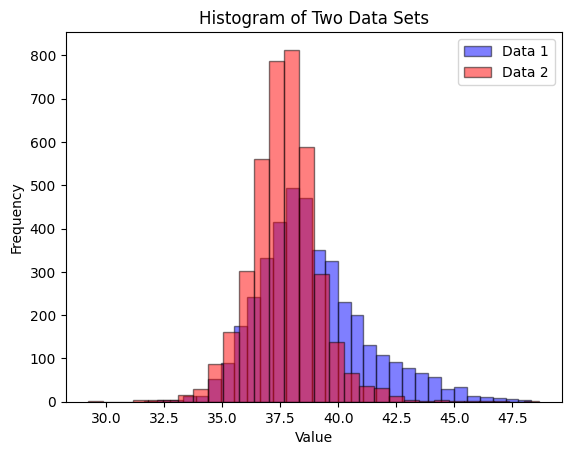

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据
data1 = sim_score  # 生成 1000 个符合正态分布的随机数
data2 = dif_score  # 生成 1000 个偏移的随机数

# 绘制直方图
plt.hist(data1, bins=30, alpha=0.5, label='Data 1', color='blue', edgecolor='black')
plt.hist(data2, bins=30, alpha=0.5, label='Data 2', color='red', edgecolor='black')

# 添加图例
plt.legend()

# 添加标题和标签
plt.title('Histogram of Two Data Sets')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示图形
plt.show()
